In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sys
import os
sys.path.insert(1, '/idia/projects/hi_im/meerpower/meerpower')
import Init
import plot
matplotlib.rcParams['figure.figsize'] = (18, 9)

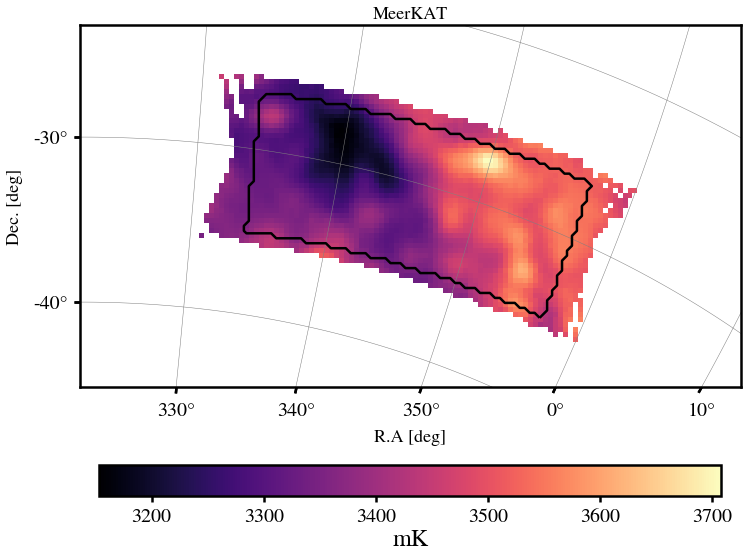

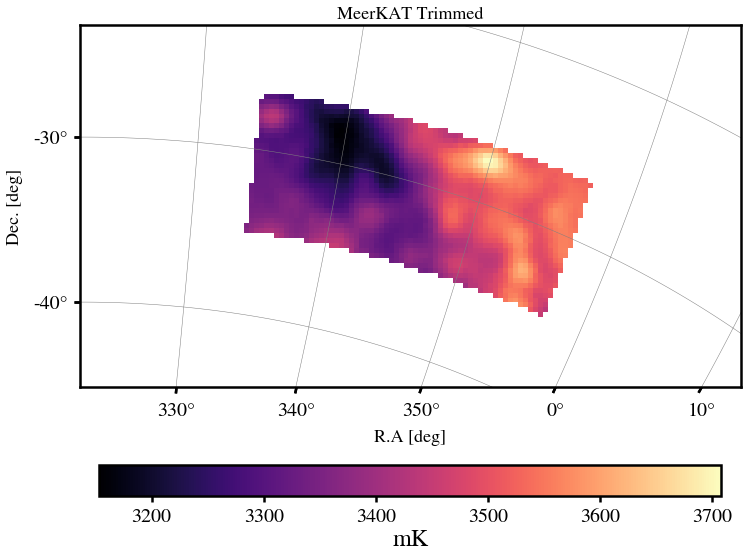

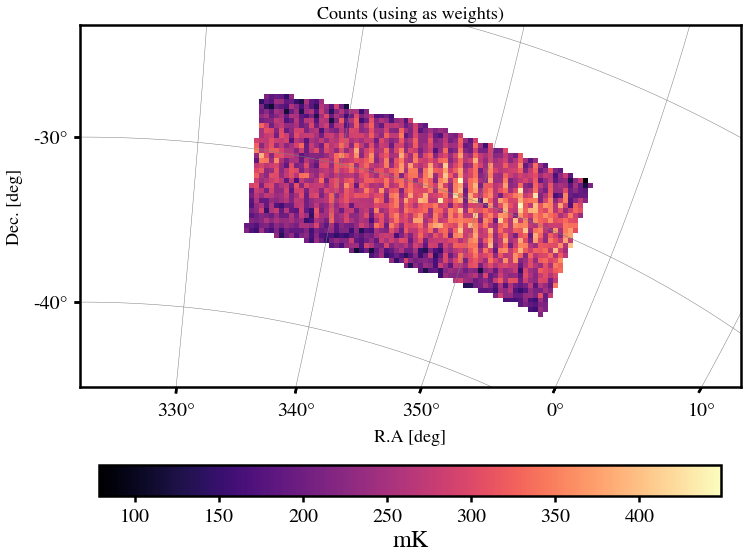

In [2]:
# Read-in level6 MeerKAT data:
#filestem = '/idia/projects/hi_im/raw_vis/MeerKLASS2021/level6/0.3/sigma_3/data/'
#map_file = filestem + 'Nscan966_Tsky_cube_p0.3d_sigma3.0_iter2.fits'
filestem = '/idia/users/jywang/MeerKLASS/calibration2021/level6/0.3/sigma4_count40/re_cali1_round5/'
map_file = filestem + 'Nscan961_Tsky_cube_p0.3d_sigma4.0_iter2.fits'
MKmap,w_HI,W_HI,counts_HI,dims,ra,dec,nu,wproj = Init.ReadIn(map_file)

### Initialise some fiducial cosmology and survey parameters:
import cosmo
nu_21cm = 1420.405751 #MHz
zeff = (nu_21cm/np.median(nu)) - 1 # Effective redshift (redshift of median frequency)
cosmo.SetCosmology(builtincosmo='Planck18',z=zeff,UseCLASS=True)
Pmod = cosmo.GetModelPk(zeff,kmax=25,UseCLASS=True) # high-kmax needed for large k-modes in NGP alisasing correction
f = cosmo.f(zeff)
sig_v = 0
b_HI = 1.5
b_g = 1.6 # tuned by eye in GAMA auto-corr
OmegaHIbHI = 0.85e-3 # MKxWiggleZ constraint
OmegaHI = OmegaHIbHI/b_HI
import HItools
import telescope
Tbar = HItools.Tbar(zeff,OmegaHI)
D_dish = 13.5 # Dish-diameter [metres]
theta_FWHM,R_beam = telescope.getbeampars(D_dish,np.median(nu))

### Remove incomplete LoS pixels from maps:
MKmap,w_HI,W_HI,counts_HI = Init.FilterIncompleteLoS(MKmap,w_HI,W_HI,counts_HI)

### Trim map edges (can fine-tune boarders if needed):
raminMK,ramaxMK = 334,357
decminMK,decmaxMK = -35,-26.5
### Before trimming map, show contour of trimmed area:
MKmap_untrim,W_HI_untrim = np.copy(MKmap),np.copy(W_HI)
plot.Map(MKmap_untrim,W=W_HI_untrim,map_ra=ra,map_dec=dec,wproj=wproj,title='MeerKAT',cbarshrink=0.6)
MKmap,w_HI,W_HI,counts_HI = Init.MapTrim(ra,dec,MKmap,w_HI,W_HI,counts_HI,ramin=raminMK,ramax=ramaxMK,decmin=decminMK,decmax=decmaxMK)
contours = plt.contour(W_HI[:,:,0].T, levels=[0.5], colors='black')
plt.show()

### Use counts map as weights:
w_HI = counts_HI # Not factorised along LoS so will add rank if used in foreground cleaning in current form

plot.Map(MKmap,W=W_HI,map_ra=ra,map_dec=dec,wproj=wproj,title='MeerKAT Trimmed',cbarshrink=0.6)
plot.Map(counts_HI,W=W_HI,map_ra=ra,map_dec=dec,wproj=wproj,title='Counts (using as weights)',cbarshrink=0.6)
plt.show()

### GAMA G23 field galaxies

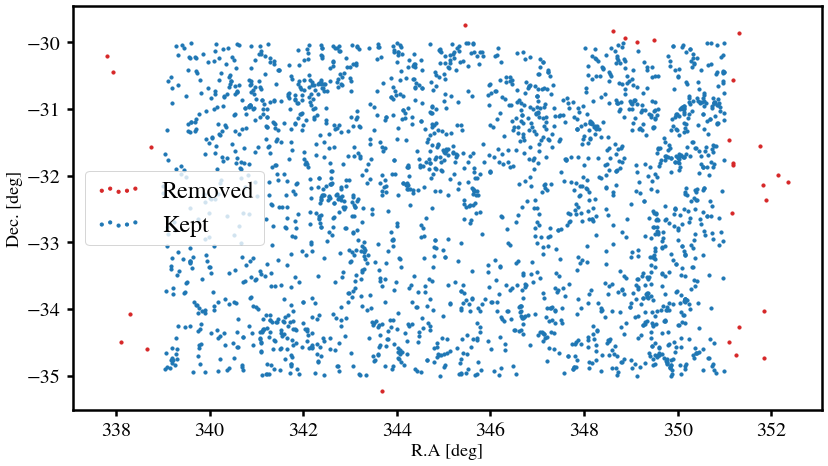

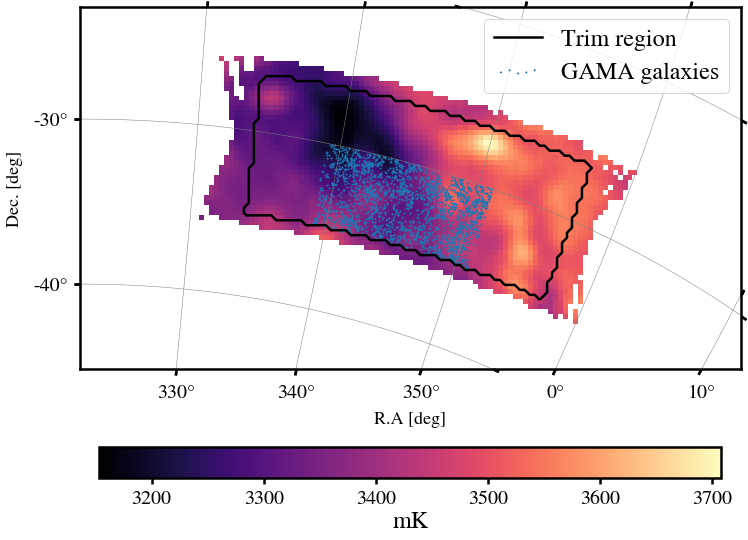

In [3]:
# Read-in GAMA galaxies:
from astropy.io import fits
Fits = '/idia/projects/hi_im/GAMA_DR4/G23TilingCatv11.fits'
hdu = fits.open(Fits)
hdr = hdu[1].header
#print(hdr)
ra_g = hdu[1].data['RA'] # Right ascension (J2000) [deg]
dec_g = hdu[1].data['DEC'] # Declination (J2000) [deg]
z_g = hdu[1].data['Z'] # Spectroscopic redshift, -1 for none attempted

### Cut redshift to MeerKAT IM range:
zmin,zmax = HItools.Freq2Red(np.max(nu)),HItools.Freq2Red(np.min(nu))
z_Lband = (z_g>zmin) & (z_g<zmax)
ra_g = ra_g[z_Lband]
dec_g = dec_g[z_Lband]
z_g = z_g[z_Lband]

### Remove galaxies outside bulk GAMA footprint so they don't bias the simple binary selection function
raminGAMA,ramaxGAMA = 339,351
decminGAMA,decmaxGAMA = -35,-30
GAMAcutmask = (ra_g>raminGAMA) & (ra_g<ramaxGAMA) & (dec_g>decminGAMA) & (dec_g<decmaxGAMA)
plt.figure(figsize=(13,7))
plt.scatter(ra_g[~GAMAcutmask],dec_g[~GAMAcutmask],s=10,label='Removed',color='tab:red')
ra_g,dec_g,z_g = ra_g[GAMAcutmask],dec_g[GAMAcutmask],z_g[GAMAcutmask]
plt.scatter(ra_g,dec_g,s=10,label='Kept',color='tab:blue')
plt.xlabel('R.A [deg]',fontsize=18)
plt.ylabel('Dec. [deg]',fontsize=18)
plt.legend()
plt.show()

### For null testing:
#np.random.shuffle(z_g)

### Plot MK map with overlaid GAMA galaxies:
plt.subplot(projection=wproj)
ax = plt.gca()
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('d')
plt.grid(True, color='grey', ls='solid',lw=0.5)
img = np.mean(MKmap_untrim,2)
img[W_HI_untrim[:,:,0]==0] = np.nan
plt.imshow(img.T)
cbar = plt.colorbar(orientation='horizontal',shrink=0.6)
cbar.set_label('mK')
contours = plt.contour(W_HI[:,:,0].T, levels=[0.5], colors='black')
plt.plot(np.nan,np.nan,color='black',label='Trim region') # dummy line for contour legend label
plt.scatter(ra_g,dec_g,transform=ax.get_transform('world'),s=1,label='GAMA galaxies',color='tab:blue')
plt.xlabel('R.A [deg]',fontsize=18)
plt.ylabel('Dec. [deg]',fontsize=18)
plt.legend()
plt.show()

### Cartesian regridding:

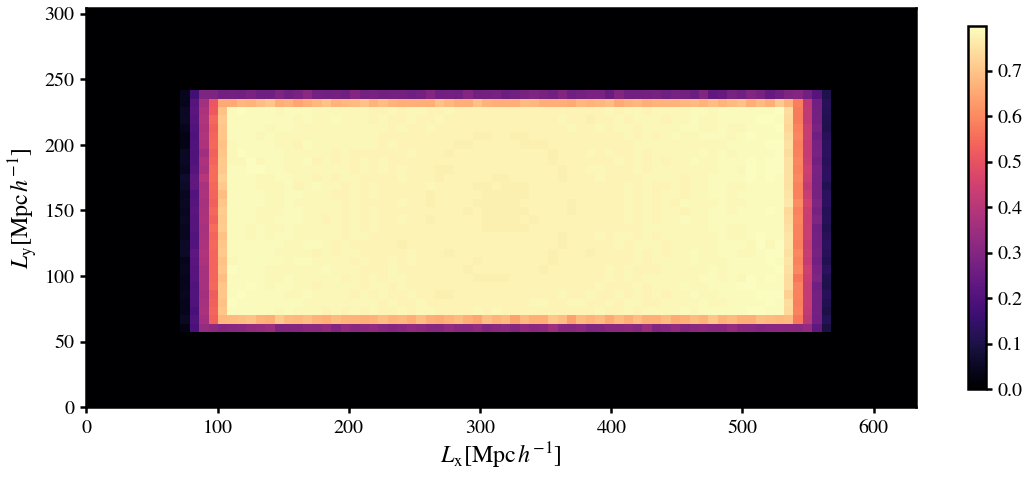

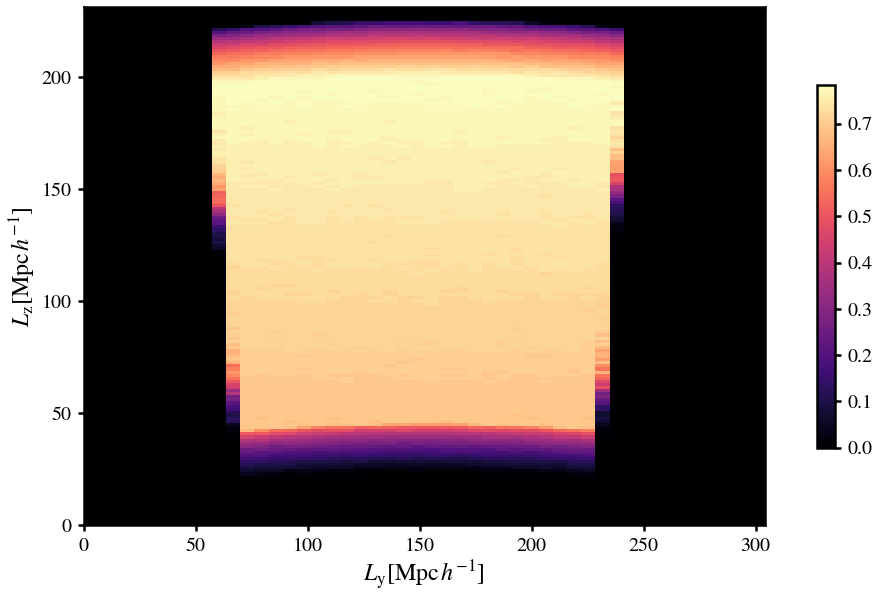

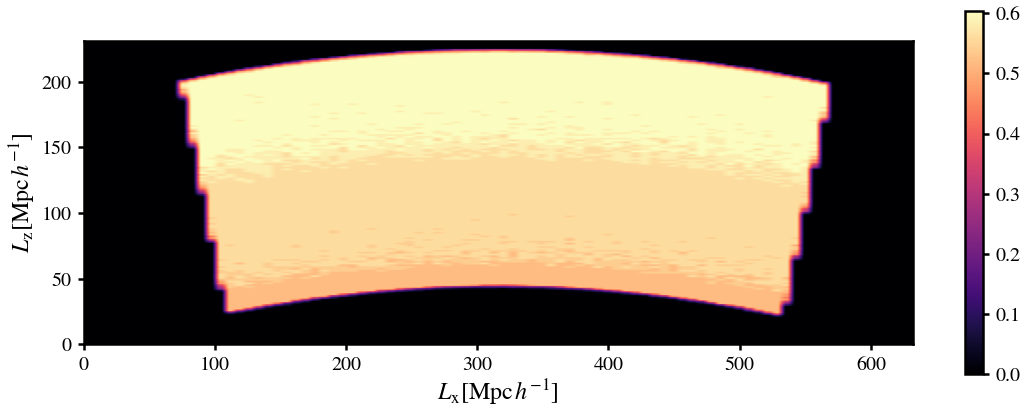

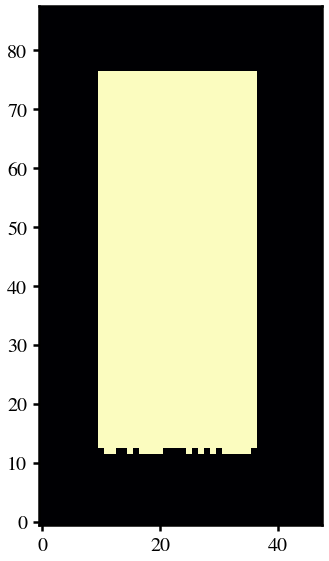

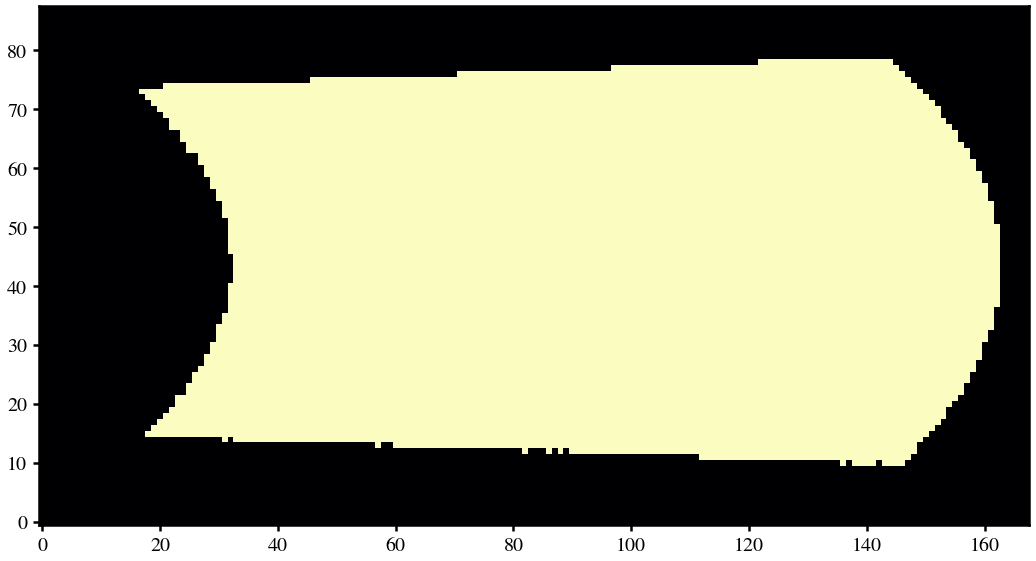

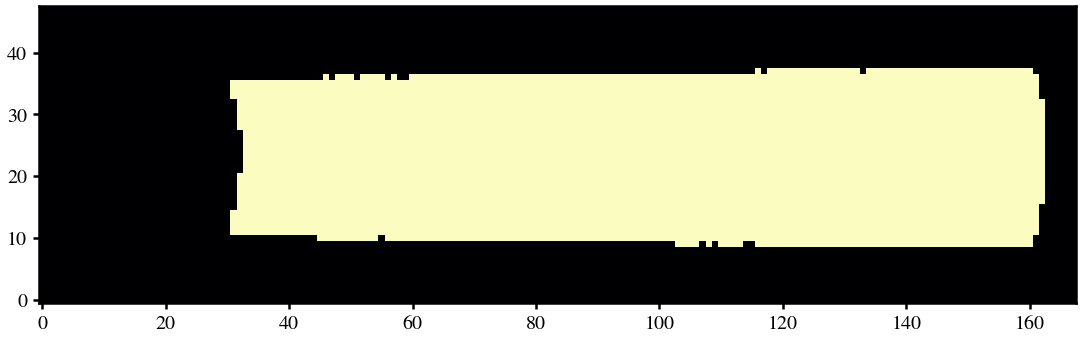

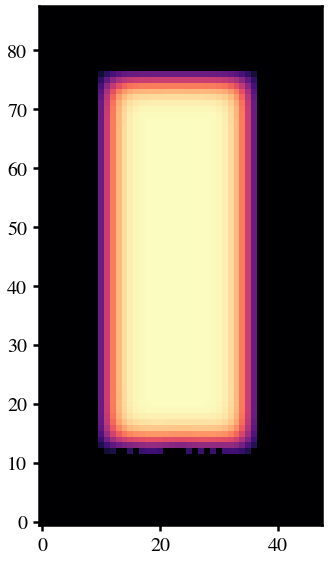

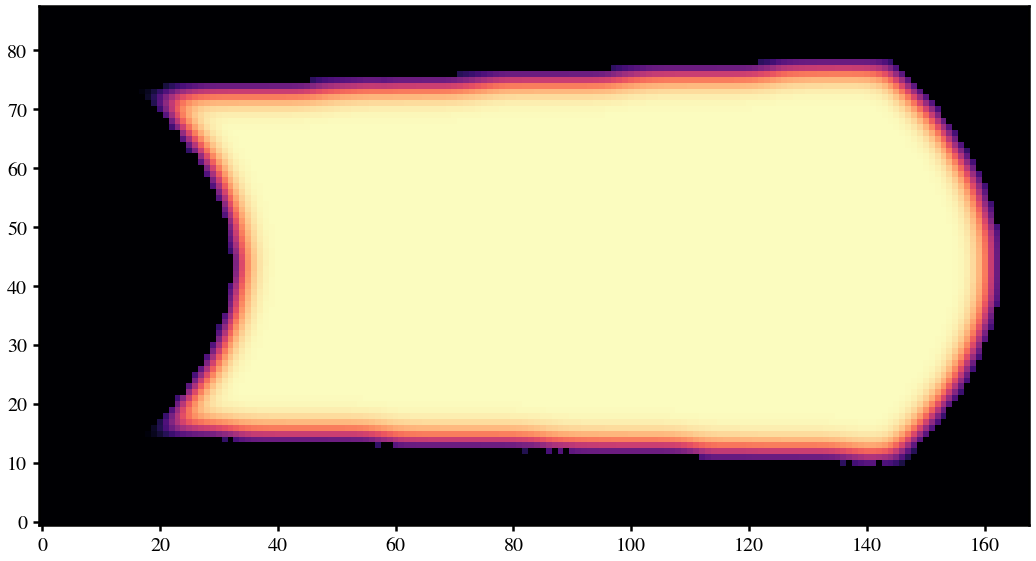

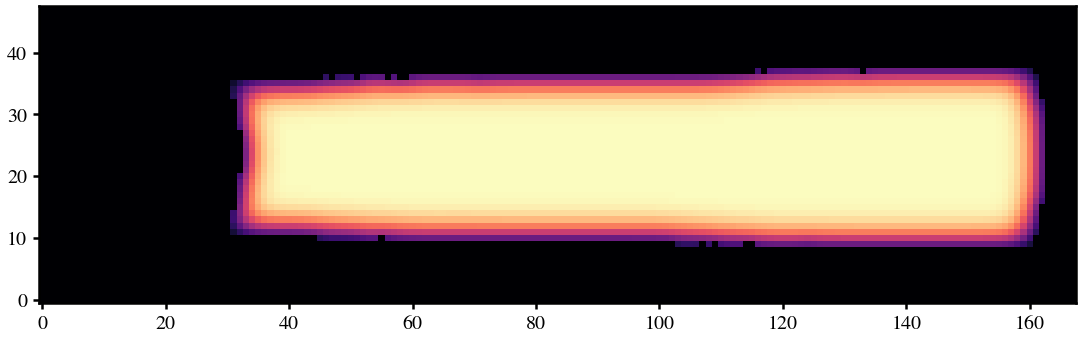

In [4]:
import grid # use this for going from (ra,dec,freq)->(x,y,z) Cartesian-comoving grid
window = 'ngp'
compensate = True
interlace = True
Np = 5 # number of Monte-Carlo sampling particles per map voxel used in regridding
nxmap,nymap,nzmap = np.shape(MKmap)
cell2vox_factor = 1.5 # increase for lower resolution FFT Cartesian grid
ndim_rg = int(nxmap/cell2vox_factor),int(nymap/cell2vox_factor),int(nzmap/cell2vox_factor)
dims_rg,dims0_rg = grid.comoving_dims(ra,dec,nu,wproj,ndim_rg,W=W_HI) # dimensions of Cartesian grid for FFT
lx,ly,lz,nx_rg,ny_rg,nz_rg = dims_rg

# Grid GAMA galaxies straight to Cartesian field:
xp,yp,zp = grid.SkyCoordtoCartesian(ra_g,dec_g,z_g,ramean_arr=ra,decmean_arr=dec,doTile=False)
n_g_rg,W_fft,counts = grid.mesh(xp,yp,zp,dims=dims0_rg,window=window,compensate=compensate,interlace=interlace,verbose=False)

# Grid uncut pixels to obtain binary masks in Cartesian space:
ra_p,dec_p,nu_p = grid.SkyPixelParticles(ra,dec,nu,wproj,Np=Np)
MKcutmask = (ra_p>raminMK) & (ra_p<ramaxMK) & (dec_p>decminMK) & (dec_p<decmaxMK)
xp,yp,zp = grid.SkyCoordtoCartesian(ra_p[MKcutmask],dec_p[MKcutmask],HItools.Freq2Red(nu_p[MKcutmask]),ramean_arr=ra,decmean_arr=dec,doTile=False)
null,W01_HI_rg,counts = grid.mesh(xp,yp,zp,dims=dims0_rg,window='ngp',compensate=False,interlace=False,verbose=False)
GAMAcutmask = (ra_p>raminGAMA) & (ra_p<ramaxGAMA) & (dec_p>decminGAMA) & (dec_p<decmaxGAMA)
xp,yp,zp = grid.SkyCoordtoCartesian(ra_p[GAMAcutmask],dec_p[GAMAcutmask],HItools.Freq2Red(nu_p[GAMAcutmask]),ramean_arr=ra,decmean_arr=dec,doTile=False)
null,W01_g_rg,counts = grid.mesh(xp,yp,zp,dims=dims0_rg,window='ngp',compensate=False,interlace=False,verbose=False)

### Show binary window averaged along each dimension for sanity check:
plt.imshow(np.mean(W01_HI_rg,2).T,extent=[0,lx,0,ly])
plt.xlabel(r'$L_{\rm x} [{\rm Mpc}\,h^{-1}$]')
plt.ylabel(r'$L_{\rm y} [{\rm Mpc}\,h^{-1}$]')
plt.colorbar(shrink=0.7)
plt.show()
plt.imshow(np.mean(W01_HI_rg,0).T,extent=[0,ly,0,lz])
plt.xlabel(r'$L_{\rm y} [{\rm Mpc}\,h^{-1}$]')
plt.ylabel(r'$L_{\rm z} [{\rm Mpc}\,h^{-1}$]')
plt.colorbar(shrink=0.7)
plt.show()
plt.imshow(np.mean(W01_HI_rg,1).T,extent=[0,lx,0,lz])
plt.xlabel(r'$L_{\rm x} [{\rm Mpc}\,h^{-1}$]')
plt.ylabel(r'$L_{\rm z} [{\rm Mpc}\,h^{-1}$]')
plt.colorbar(shrink=0.7)
plt.show()

# Regrid IM weights to Cartesian field (regrid HI IM map later after foreground cleaning):
ra_p,dec_p,nu_p,pixvals = grid.SkyPixelParticles(ra,dec,nu,wproj,map=w_HI,W=W_HI,Np=Np)
xp,yp,zp = grid.SkyCoordtoCartesian(ra_p,dec_p,HItools.Freq2Red(nu_p),ramean_arr=ra,decmean_arr=dec,doTile=False)
w_HI_rg,W_fft,counts = grid.mesh(xp,yp,zp,pixvals,dims0_rg,window,compensate,interlace,verbose=False)

# Create tapering to apply to Cartesian fields
# - needs to taper a conical footprint so currently using a technique that Gaussian smooths inwards from the empty edges:
doTaper = True # Implement apodisation window functions to apply to maps and weights to taper edges
if doTaper==True:
    # Gaussian smoothing from empty edges:
    taper_HI = np.copy(W01_HI_rg)
    taper_g = np.copy(W01_g_rg)
    from scipy.ndimage import gaussian_filter
    for i in range(8):
        taper_HI = gaussian_filter(taper_HI, sigma=1, mode='reflect')
        taper_HI[W01_HI_rg==0] = 0
        taper_g = gaussian_filter(taper_g, sigma=1, mode='reflect')
        taper_g[W01_g_rg==0] = 0
if doTaper==False: taper_HI,taper_g = 1,1

### Plots to check tapering of conical footprint is working:
taper_plot = np.copy(taper_HI)
no_taper_plot = np.copy(W01_HI_rg)
#taper_plot = np.copy(taper_g)
#no_taper_plot = np.copy(W01_g_rg)
plt.imshow(no_taper_plot[:,:,int(nz_rg/2)])
plt.figure()
plt.imshow(no_taper_plot[:,int(ny_rg/2),:])
plt.figure()
plt.imshow(no_taper_plot[int(nx_rg/2),:,:])
plt.figure()
plt.imshow(taper_plot[:,:,int(nz_rg/2)])
plt.figure()
plt.imshow(taper_plot[:,int(ny_rg/2),:])
plt.figure()
plt.imshow(taper_plot[int(nx_rg/2),:,:])
plt.show()

# Multiply tapering window by all galaxy fields that undergo Fourier transforms
n_g_rg = taper_g*n_g_rg
W01_g_rg = taper_g*W01_g_rg
w_g_rg = np.ones(np.shape(n_g_rg))
w_g_rg = taper_g*w_g_rg
# Multiply tapering window by HI weights and window (final HI IM field is tapered later after foreground cleaning)
w_HI_rg,W01_HI_rg = taper_HI*w_HI_rg,taper_HI*W01_HI_rg

### Power spectrum measurement and modelling:

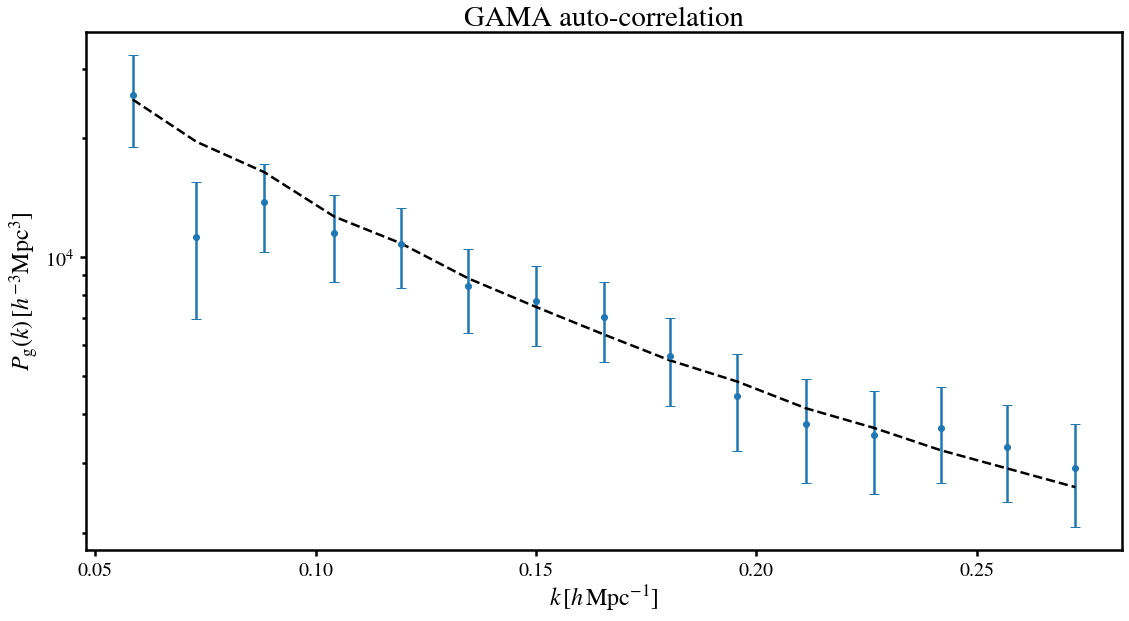

0
1
2
3
4
5


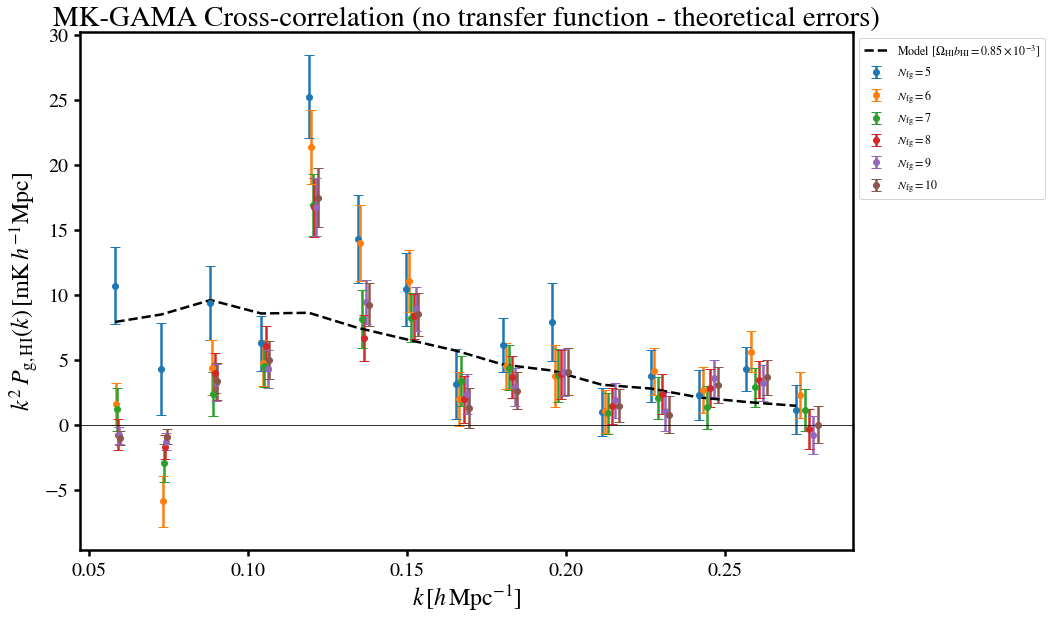

In [5]:
import foreground
import power # All power spectrum calculations performed in this script
import model
nkbin = 15
kmin,kmax = 0.05,0.28
kbins = np.linspace(kmin,kmax,nkbin+1) # k-bin edges [using linear binning]
kcuts = None
#kcuts = [None,0.01,0.2,None] #[kperpmin,kparamin,kperpmax,kparamax] (exclude areas of k-space from spherical average)

### GAMA Auto-power (use to constrain bias):
Pk_g,k,nmodes = power.Pk(n_g_rg,n_g_rg,dims_rg,kbins,corrtype='Galauto',w1=w_g_rg,w2=w_g_rg,W1=W01_g_rg,W2=W01_g_rg)
nbar = np.sum(n_g_rg)/(lx*ly*lz) # Calculate number density inside survey footprint
P_SN = np.ones(len(k))*1/nbar # approximate shot-noise for errors (already subtracted in Pk estimator)
pkmod,k = model.PkMod(Pmod,dims_rg,kbins,b_g,b_g,f,sig_v,Tbar1=1,Tbar2=1,r=1,R_beam1=0,R_beam2=0,w1=w_g_rg,w2=w_g_rg,W1=W01_g_rg,W2=W01_g_rg,interpkbins=True,MatterRSDs=False,gridinterp=True)[0:2]
sig_g = 1/np.sqrt(nmodes)*(Pk_g+P_SN)
plt.errorbar(k,Pk_g,sig_g,ls='none',marker='o')
plt.plot(k,pkmod,color='black',ls='--',label=r'Model [$\Omega_{\rm HI}b_{\rm HI} = %s \times 10^{-3}]$'%np.round(OmegaHI*b_HI*1e3,2))
plt.yscale('log')
plt.title('GAMA auto-correlation')
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$P_{\rm g}(k)\,[h^{-3}{\rm Mpc}^{3}]$')
plt.axhline(0,lw=0.8,color='black')
plt.show()

# Chose factorisation of P(k) in plotting:
#norm = np.ones(nkbin)
norm = k**2

#N_fgs = [5,6,7,8]
N_fgs = [5,6,7,8,9,10]
indx_choice = 2 # Make N_fg index choice to show covariance, 2D power and final error results for

### Foreground clean and measure cross power spectra:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']
for i in range(len(N_fgs)):
    print(i)
    MKmap_clean = foreground.PCAclean(MKmap,N_fg=N_fgs[i],W=W_HI,w=None)
    '''
    shuffleindex = np.arange(0,nz,1)
    np.random.shuffle(shuffleindex)
    MKmap_clean = MKmap_clean[:,:,shuffleindex]
    '''
    # Regrid cleaned map to Cartesian field:
    ra_p,dec_p,nu_p,pixvals = grid.SkyPixelParticles(ra,dec,nu,wproj,map=MKmap_clean,W=W_HI,Np=Np)
    xp,yp,zp = grid.SkyCoordtoCartesian(ra_p,dec_p,HItools.Freq2Red(nu_p),ramean_arr=ra,decmean_arr=dec,doTile=False)
    MKmap_clean_rg_i,W_fft,counts = grid.mesh(xp,yp,zp,pixvals,dims0_rg,window,compensate,interlace,verbose=False)

    # Multiply tapering window by all cleaned map:
    MKmap_clean_rg_i = taper_HI*MKmap_clean_rg_i

    # Measure and plot power spectrum:
    Pk_HI,k,nmodes = power.Pk(MKmap_clean_rg_i,MKmap_clean_rg_i,dims_rg,kbins,corrtype='HIauto',w1=w_HI_rg,w2=w_HI_rg,W1=W01_HI_rg,W2=W01_HI_rg,kcuts=kcuts)
    Pk_X_i,k,nmodes = power.Pk(MKmap_clean_rg_i,n_g_rg,dims_rg,kbins,corrtype='Cross',w1=w_HI_rg,w2=W01_g_rg,W1=W01_HI_rg,W2=W01_g_rg,kcuts=kcuts)
    sig_err = 1/np.sqrt(2*nmodes) * np.sqrt( Pk_X_i**2 + Pk_HI*( Pk_g + P_SN ) ) # Error estimate
    plt.errorbar(k+(k/200*i),norm*Pk_X_i,norm*sig_err,label=r'$N_{\rm fg}=%s$'%N_fgs[i],ls='none',marker='o',color=colors[i])

    if i==indx_choice:
        Pk_X = Pk_X_i
        MKmap_clean_rg = MKmap_clean_rg_i

# Model power spectrum:
sig_v = 400
dpix = 0.3
d_c = cosmo.d_com(HItools.Freq2Red(np.min(nu)))
s_pix = d_c * np.radians(dpix)
s_para = np.mean( cosmo.d_com(HItools.Freq2Red(nu[:-1])) - cosmo.d_com(HItools.Freq2Red(nu[1:])) )
pkmod,k = model.PkMod(Pmod,dims_rg,kbins,b_HI,b_g,f,sig_v,Tbar1=Tbar,Tbar2=1,r=1,R_beam1=R_beam,R_beam2=0,w1=W01_HI_rg,w2=W01_g_rg,W1=W01_HI_rg,W2=W01_g_rg,s_pix=s_pix,s_para=s_para,interpkbins=True,MatterRSDs=False,gridinterp=True)[0:2]
plt.plot(k,norm*pkmod,color='black',ls='--',label=r'Model [$\Omega_{\rm HI}b_{\rm HI} = %s \times 10^{-3}]$'%np.round(OmegaHI*b_HI*1e3,2))

if norm[0]==1.0: plt.yscale('log')
plt.legend(fontsize=12,loc='upper left',bbox_to_anchor=[1,1])
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
if norm[0]==1.0: plt.ylabel(r'$P_{\rm g,HI}(k)\,[{\rm mK}\,h^{-3}{\rm Mpc}^{3}]$')
else: plt.ylabel(r'$k^2\,P_{\rm g,HI}(k)\,[{\rm mK}\,h^{-1}{\rm Mpc}]$')
plt.axhline(0,lw=0.8,color='black')
plt.subplots_adjust(right=0.75)
#plt.title('Null Test (shuffled GAMA redshifts) MeerKAT 2021 x GAMA (no TF)')
plt.title('MK-GAMA Cross-correlation (no transfer function - theoretical errors)')
plt.show()

### Calculate/Load Transfer function:
##### - use to correct signal loss, analyse covariance and assign errors:

Errors for the reconstructed power spectrum $P_{\rm rec}(k) = P_{\rm clean}(k)/T(k)$ are propagated from the transfer function distributions $T(k)+\Delta T_i(k)$ obtained from each $i$th mock. We assume the errors add in quadrature, hence $\Delta P_{{\rm rec},i}/P_{\rm rec} = \sqrt{(\Delta P_{{\rm clean},i}/P_{\rm clean})^2 + (\Delta T_i/T)^2}$. We assume all quantifiable error lies in the TF distribution, hence $\Delta P_{{\rm clean},i} = 0$ and therefore $\Delta P_{{\rm rec},i} = P_{\rm rec} \frac{{\Delta T},i}{T}$. The uncertainties for the error bars can then be obtained from the 68th percentile regions of the reconstructed power distribution $P_{{\rm rec},i}(k) = P_{\rm rec}(k) + \Delta P_{{\rm rec},i}(k)$ 

500


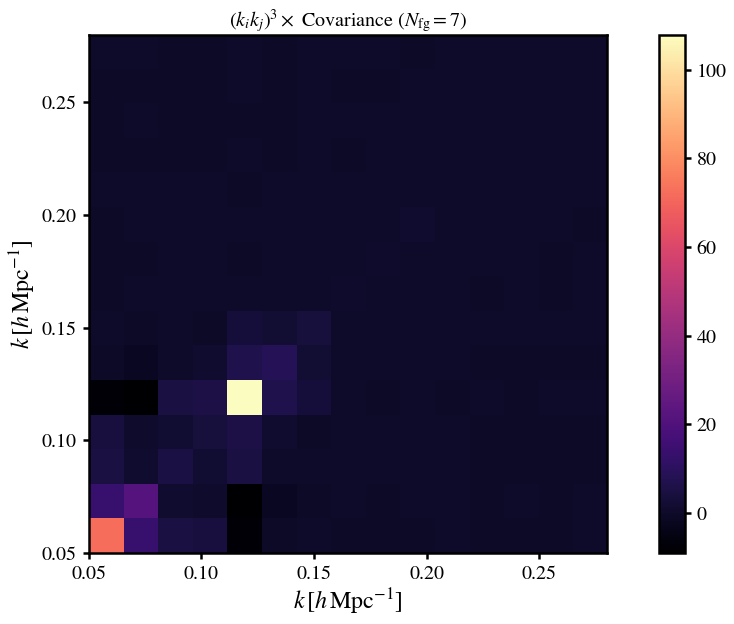

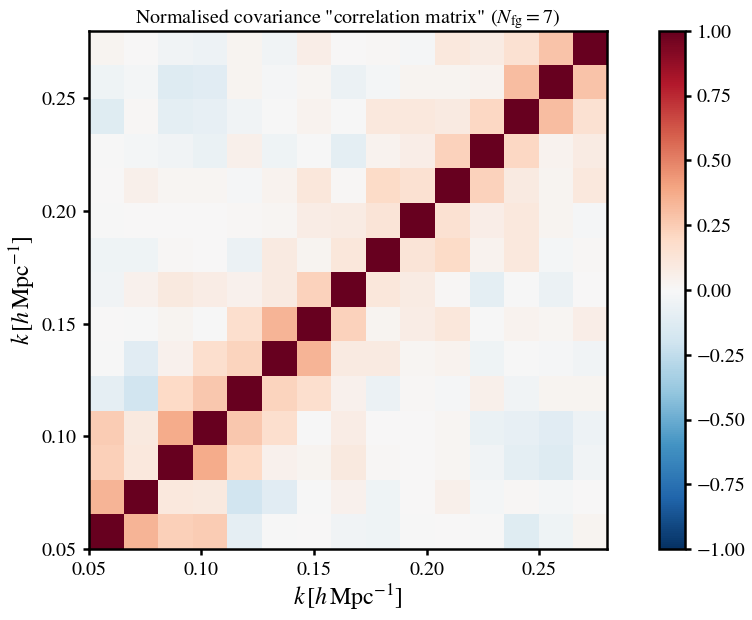

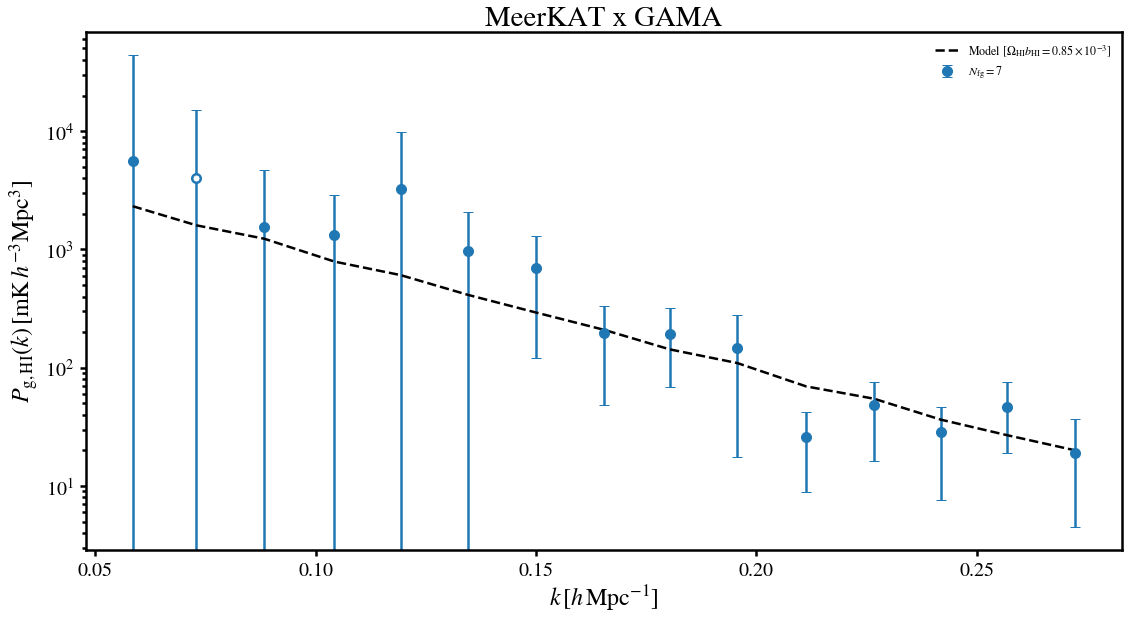

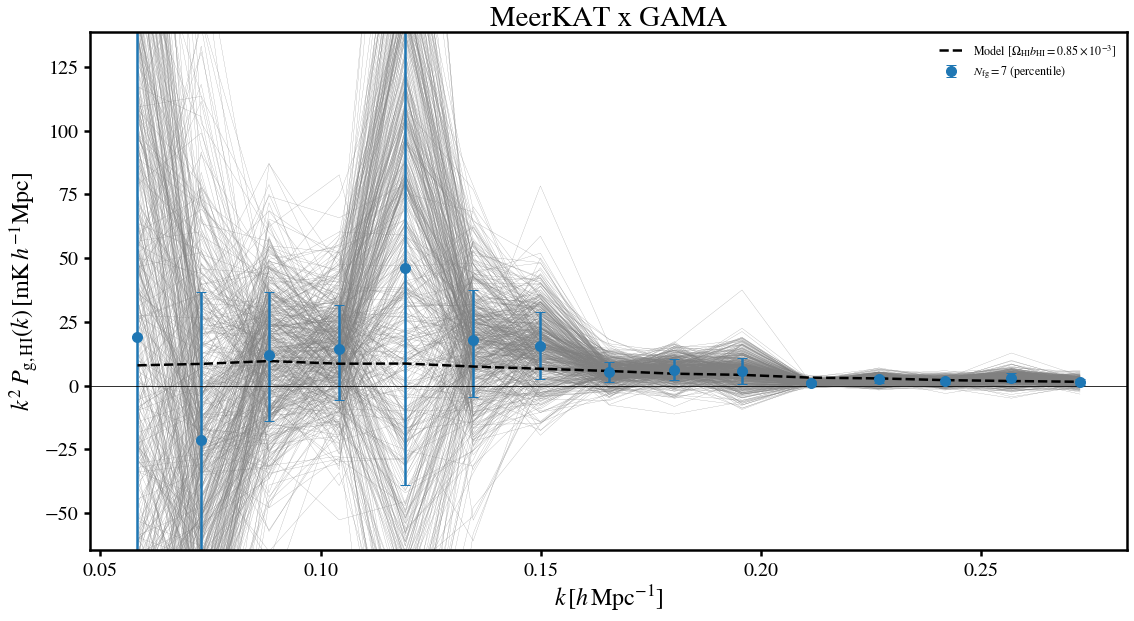

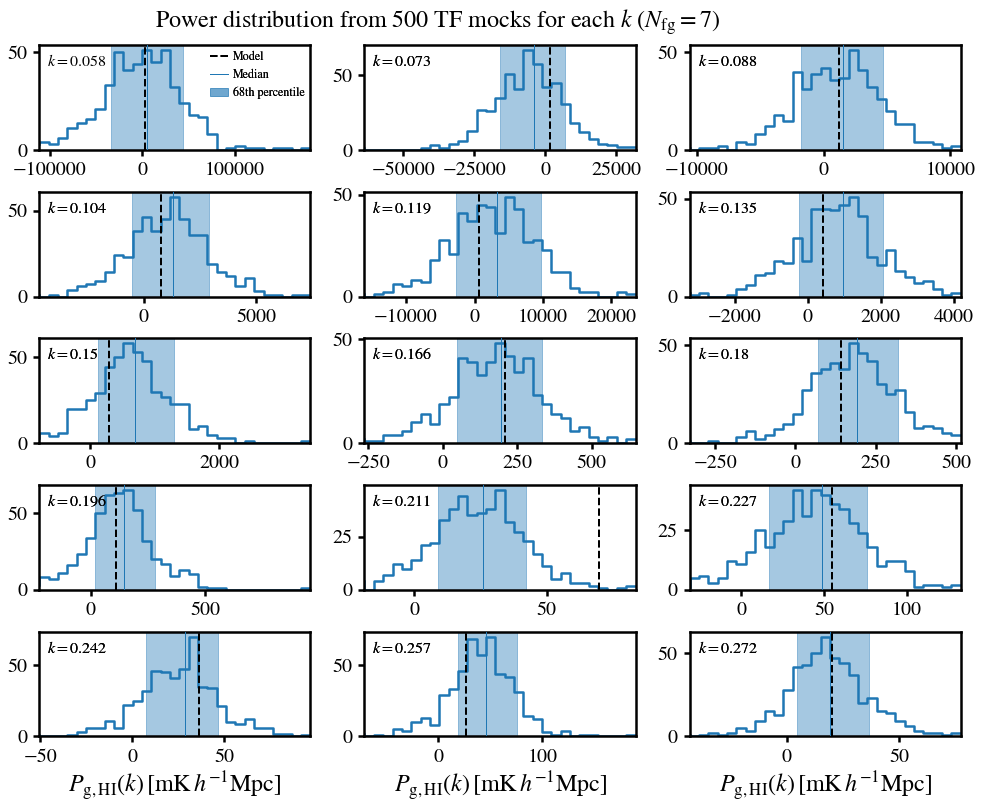


Detection Significance: 3.378 sigma
Reduced Chi^2: 0.6680697304156982


In [6]:
LoadTF = True
Nmock = 500
TFfile = '/users/scunnington/hi_im/meerpower/2021Lband/gama/TFdata/T_Nfg=%s'%N_fgs[indx_choice]
mockfilepath_HI = '/idia/projects/hi_im/meerpower/2021Lband/mocks/dT_HI_p0.3d_wBeam'
mockfilepath_g = '/idia/projects/hi_im/meerpower/2021Lband/mocks/mockGAMAcat'
T_wsub_i, T_nosub_i,k = foreground.TransferFunction(MKmap,Nmock,N_fgs[indx_choice],'Cross',kbins,k,TFfile,mockfilepath_HI,mockfilepath_g,W_HI,w_HI_rg,W01_HI_rg,W01_g_rg,W01_g_rg,ra,dec,nu,wproj,dims0_rg,Np,window,compensate,interlace,taper_HI,taper_g,LoadTF)
Nmock = np.shape(T_wsub_i)[0]
print(Nmock)

#T_i = np.copy(T_wsub_i)
T_i = np.copy(T_nosub_i)
T = np.median(T_i,0)
#T = np.mean(T_wsub_i,0)
deltaT_i = T_i - T
Pk_rec = Pk_X/T

# Propagate error on TF into error on power:
deltaPk_i =  Pk_rec * (deltaT_i/T) 
Pk_rec_i = Pk_rec + deltaPk_i # corrected power uncertainty distribution

# Calculate 68th percentile regions for non-symmetric/non-Gaussian errors:
### 68.27%/2 = 34.135%. So 50-34.135 -> 50+34.135 covers 68th percentile region:
lower_error = np.abs(np.percentile(deltaPk_i,15.865,axis=0))
upper_error = np.abs(np.percentile(deltaPk_i,84.135,axis=0))
asymmetric_error = np.array(list(zip(lower_error, upper_error))).T

# k-bin covariance from TF:
kgrid = k * k[:,np.newaxis]
C = kgrid**3*np.cov(Pk_rec_i,rowvar=False)
plt.imshow(C,origin='lower',extent=[kbins[0],kbins[-1],kbins[0],kbins[-1]])
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.colorbar()
plt.title(r'$(k_ik_j)^3\times$ Covariance ($N_{\rm fg}=%s$)'%N_fgs[indx_choice],fontsize=20)
plt.show()

# Noramlised k-bin correlation matrix:
R = np.corrcoef(Pk_rec_i,rowvar=False)
plt.imshow(R,origin='lower',cmap='RdBu_r',vmin=-1,vmax=1,extent=[kbins[0],kbins[-1],kbins[0],kbins[-1]])
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.colorbar()
plt.title(r'Normalised covariance "correlation matrix" ($N_{\rm fg}=%s$)'%N_fgs[indx_choice],fontsize=20)
plt.show()

# Plot results, correcting for signal loss and with simulation-based errors:
# Chose factorisation of P(k) in plotting:
norm = np.ones(nkbin)
#norm = k**2

plt.errorbar(k,norm*np.abs(Pk_rec),norm*asymmetric_error,ls='none',marker='o',label=r'$N_{\rm fg}=%s$'%N_fgs[indx_choice],markersize=10)
plt.scatter(k[Pk_rec<0],norm[Pk_rec<0]*np.abs(Pk_rec[Pk_rec<0]),marker='o',facecolors='white',color='tab:blue',zorder=10,s=50)
plt.plot(k,norm*pkmod,color='black',ls='--',label=r'Model [$\Omega_{\rm HI}b_{\rm HI} = %s \times 10^{-3}]$'%np.round(OmegaHI*b_HI*1e3,2))
if norm[0]==1.0: plt.yscale('log')
plt.axhline(0,lw=0.8,color='black')
plt.legend(fontsize=12,loc='upper right',frameon=False)
plt.title('MeerKAT x GAMA')
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
if norm[0]==1.0: plt.ylabel(r'$P_{\rm g,HI}(k)\,[{\rm mK}\,h^{-3}{\rm Mpc}^{3}]$')
else: plt.ylabel(r'$k^2\,P_{\rm g,HI}(k)\,[{\rm mK}\,h^{-1}{\rm Mpc}]$')
plt.show()

for i in range(Nmock):
    plt.plot(k,k**2*Pk_rec_i[i],lw=0.2,color='gray',zorder=-1)
plt.errorbar(k,k**2*Pk_rec,k**2*asymmetric_error,ls='none',marker='o',label=r'$N_{\rm fg}=%s$ (percentile)'%N_fgs[indx_choice],markersize=10)
#plt.errorbar(k*1.01,k**2*Pk_rec,k**2*np.std(Pk_X/T_nosub,0),ls='none',marker='o',label=r'$N_{\rm fg}=%s$ (rms)'%N_fgs[indx_choice],markersize=10,alpha=0.5)
plt.plot(k,k**2*pkmod,color='black',ls='--',label=r'Model [$\Omega_{\rm HI}b_{\rm HI} = %s \times 10^{-3}]$'%np.round(OmegaHI*b_HI*1e3,2))
plt.axhline(0,lw=0.8,color='black')
plt.legend(fontsize=12,loc='upper right',frameon=False)
plt.title('MeerKAT x GAMA')
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$k^2\,P_{\rm g,HI}(k)\,[{\rm mK}\,h^{-1}{\rm Mpc}]$')
plt.ylim(-3*np.abs(np.min(k**2*Pk_rec)),3*np.max(k**2*Pk_rec))
plt.show()

### Histogram of TF mock distributions to show error profile for each k-bin:
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(16,12))
k_ind = 0
for row in ax:
    for col in row:
        dum, = col.plot(0,label=r'$k=%s$'%np.round(k[k_ind],3),color='white') # dummy line to show k-value in legend
        legend1 = col.legend([dum], [r'$k=%s$'%np.round(k[k_ind],3)], loc='upper left',fontsize=16,handlelength=0,handletextpad=0,frameon=False,borderaxespad=0.1)
        col.add_artist(legend1)
        mod = col.axvline(pkmod[k_ind],color='black',ls='--',lw=2,zorder=8)
        median = col.axvline(np.median(Pk_rec_i[:,k_ind]),color='tab:blue',ls='-',lw=1,zorder=9)
        span = col.axvspan(np.percentile(Pk_rec_i[:,k_ind],50-34.1,axis=0), np.percentile(Pk_rec_i[:,k_ind],50+34.1,axis=0), alpha=0.4, color='tab:blue',zorder=-10,label='68th percentile')
        if k_ind==0:
            legend2 = col.legend([mod,median,span], ['Model','Median','68th percentile'], loc='upper right',fontsize=12,frameon=False,handlelength=1.5,handletextpad=0.4,borderaxespad=0.1)
            col.add_artist(legend2)
        hist,bins = np.histogram(Pk_rec_i[:,k_ind],bins=30)
        bins = (bins[1:] + bins[:-1])/2
        col.plot(bins,hist,ds='steps')
        col.set_xlim(bins[0],bins[-1])
        col.set_ylim(0)
        if k_ind>=12: col.set_xlabel(r'$P_{\rm g,HI}(k)\,[{\rm mK}\,h^{-1}{\rm Mpc}]$')
        k_ind += 1
plt.subplots_adjust(hspace=0.4)
plt.suptitle(r'Power distribution from %s TF mocks for each $k$ ($N_{\rm fg}=%s$)'%(Nmock,N_fgs[indx_choice]))
plt.show()

### Analyse Chi^2 and detection significance (requires an assumption of Gaussian distribution in uncertainties so take the mean of the 68th percentile boundaries):
#kbin_cut = k>0
kbin_cut = k>0.075
#kbin_cut = k>0.14
det_sig = model.DetectionSigma(Pk_rec[kbin_cut],pkmod[kbin_cut],np.mean(asymmetric_error,0)[kbin_cut])
print('Reduced Chi^2: ' + str(model.ChiSquare(Pk_rec[kbin_cut],pkmod[kbin_cut],np.mean(asymmetric_error,0)[kbin_cut],dof=len(k[kbin_cut]))))

### Compare Transfer functions:

500


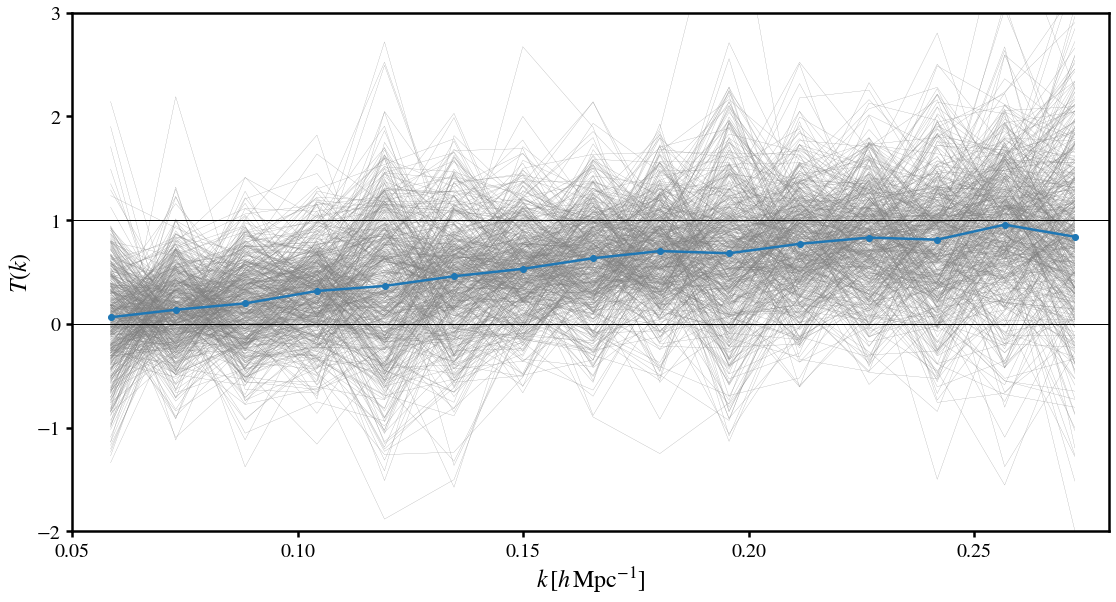

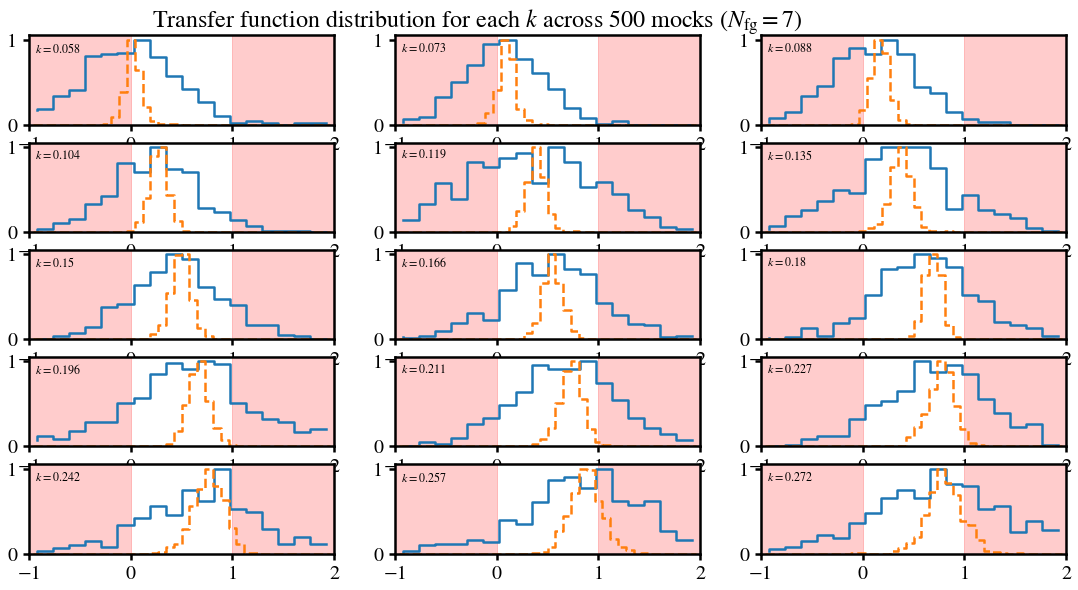

500
500
500
500
500
500


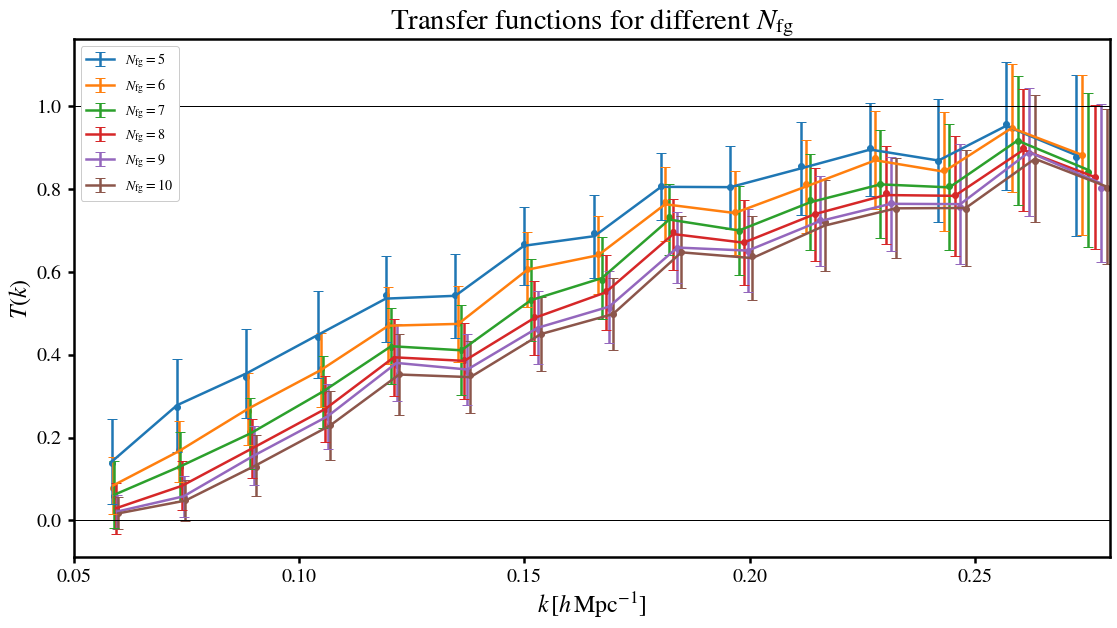

In [7]:
LoadTF = True
Nmock = 500
TFfile = '/users/scunnington/hi_im/meerpower/2021Lband/gama/TFdata/T_Nfg=%s'%N_fgs[indx_choice]
mockfilepath_HI = '/idia/projects/hi_im/meerpower/2021Lband/mocks/dT_HI_p0.3d_wBeam'
mockfilepath_g = '/idia/projects/hi_im/meerpower/2021Lband/mocks/mockGAMAcat'
T_wsub_i,T_nosub_i,k = foreground.TransferFunction(MKmap,Nmock,N_fgs[indx_choice],'Cross',kbins,k,TFfile,mockfilepath_HI,mockfilepath_g,W_HI,w_HI_rg,W01_HI_rg,W01_g_rg,W01_g_rg,ra,dec,nu,wproj,dims0_rg,Np,window,compensate,interlace,taper_HI,taper_g,LoadTF)
Nmock = np.shape(T_wsub_i)[0]
print(Nmock)

for i in range(Nmock):
    plt.plot(k,T_nosub_i[i],lw=0.2,color='gray')
plt.plot(k,np.median(T_nosub_i,0),marker='o')
plt.axhline(0,color='black',lw=1)
plt.axhline(1,color='black',lw=1)
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$T(k)$')
plt.xlim(kbins[0],kbins[-1])
plt.ylim(-2,3)
plt.show()

### Histogram of TFs for each k-bin to show distribution:
fig, ax = plt.subplots(nrows=5, ncols=3)
k_ind = 0
for row in ax:
    for col in row:
        col.axvline(np.median(T_nosub_i[:,k_ind]),color='black',ls='--',lw=0,label=r'$k=%s$'%np.round(k[k_ind],3))
        col.axvspan(-1, 0, alpha=0.2, color='red')
        col.axvspan(1, 2, alpha=0.2, color='red')
        hist,bins = np.histogram(T_nosub_i[:,k_ind],bins=np.linspace(-1,2,20))
        hist = hist/np.max(hist)
        bins = (bins[1:] + bins[:-1])/2
        col.plot(bins,hist,ds='steps')
        hist,bins = np.histogram(T_wsub_i[:,k_ind],bins=np.linspace(-1,2,40))
        hist = hist/np.max(hist)
        bins = (bins[1:] + bins[:-1])/2
        col.plot(bins,hist,ds='steps',ls='--')
        col.legend(loc='upper left',fontsize=12,handlelength=0,handletextpad=0,frameon=False,borderaxespad=0.1)
        col.set_xlim(-1,2)
        col.set_ylim(0)
        k_ind += 1
plt.suptitle(r'Transfer function distribution for each $k$ across %s mocks ($N_{\rm fg}=%s$)'%(Nmock,N_fgs[indx_choice]))
plt.show()
        
N_fgs_TF = [5,6,7,8,9,10]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']
for i in range(len(N_fgs_TF)):
    TFfile = '/users/scunnington/hi_im/meerpower/2021Lband/gama/TFdata/T_Nfg=%s'%N_fgs_TF[i]
    mockfilepath_HI = '/idia/projects/hi_im/meerpower/2021Lband/mocks/dT_HI_p0.3d_wBeam'
    mockfilepath_g = '/idia/projects/hi_im/meerpower/2021Lband/mocks/mockGAMAcat'
    T_wsub_i,T_nosub_i,k = foreground.TransferFunction(MKmap,Nmock,N_fgs[indx_choice],'Cross',kbins,k,TFfile,mockfilepath_HI,mockfilepath_g,W_HI,w_HI_rg,W01_HI_rg,W01_g_rg,W01_g_rg,ra,dec,nu,wproj,dims0_rg,Np,window,compensate,interlace,taper_HI,taper_g,LoadTF)
    Nmock = np.shape(T_wsub_i)[0]
    print(Nmock)
    plt.errorbar(k+(k/200*i),np.mean(T_wsub_i,0),np.std(T_wsub_i,0),label=r'$N_{\rm fg}{=}%s$'%N_fgs_TF[i])
    plt.scatter(k+(k/200*i),np.median(T_wsub_i,0))
plt.axhline(0,color='black',lw=1)
plt.axhline(1,color='black',lw=1)
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$T(k)$')
plt.title(r'Transfer functions for different $N_{\rm fg}$')
plt.legend(fontsize=14,framealpha=1)
plt.xlim(kbins[0],kbins[-1])
plt.show()

### Jackknife approach for error analysis:
# - NOT CURRENTLY GIVING VERY SENSIBLE LOOKING ERRORS ON LARGE SCALES ???

72


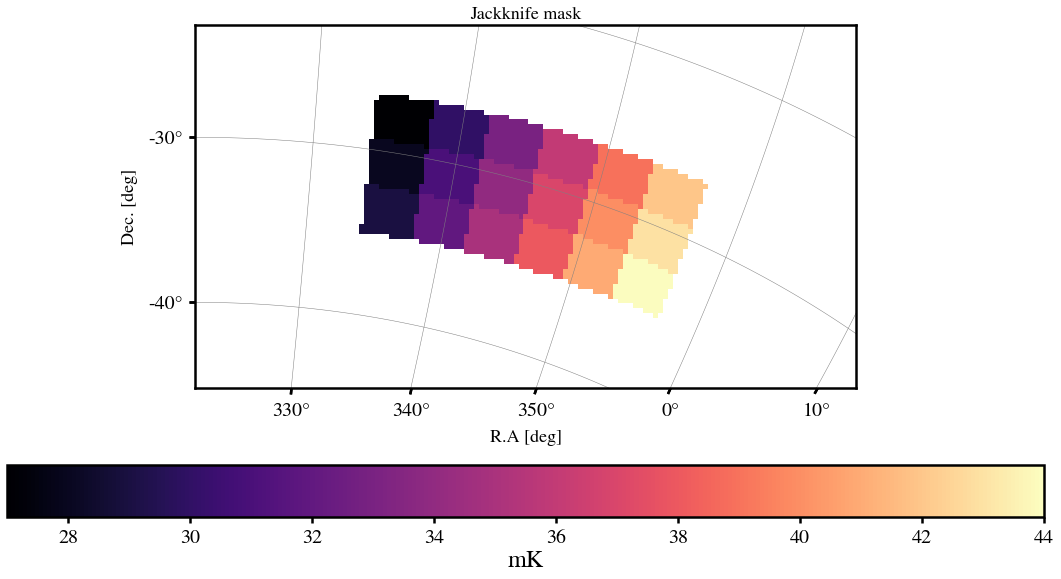

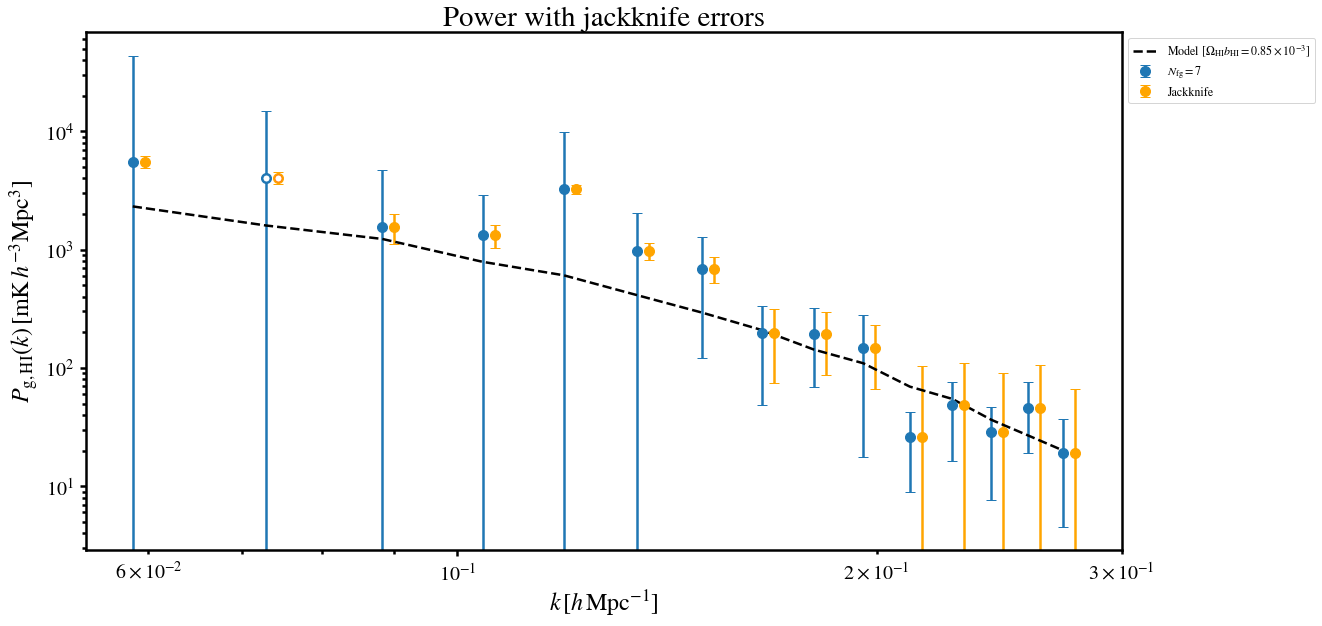

In [8]:
### Chose number of jackknife sub-samples based on how much to split data along each dimension:
nrajack = 7
ndecjack = 4
nzjack = 4

ra_jacks = np.linspace(334,357,nrajack)
dec_jacks = np.linspace(-26.5,-35,ndecjack)
nzi = np.linspace(0,nzmap-1,nzmap)
njack = (len(ra_jacks)-1) * (len(dec_jacks)-1)

print(njack*nzjack)

jackmask = np.zeros((nxmap,nymap,nzmap))
jacklabel = 0
for i in range(len(ra_jacks)-1):
    for j in range(len(dec_jacks)-1):
        jackmask[ (ra>ra_jacks[i]) & (ra<ra_jacks[i+1]) & (dec<dec_jacks[j])  & (dec>dec_jacks[j+1]) ] = jacklabel
        jacklabel += 1
for l in range(nzjack):# this makes nzjack layers of jackknife indices along frequency
    jackmask[:,:,int(l*nzmap/nzjack):int((l+1)*nzmap/nzjack)] += l*njack

jackmask = Init.MapTrim(ra,dec,jackmask,ramin=raminMK,ramax=ramaxMK,decmin=decminMK,decmax=decmaxMK)
plot.Map(jackmask,W=W_HI,map_ra=ra,map_dec=dec,wproj=wproj,title='Jackknife mask')
plt.show()

'''
MKmap_clean = foreground.PCAclean(MKmap,N_fg=N_fgs[indx_choice],W=W_HI,w=None)
Pk_jack = np.zeros((njack*nzjack,nkbin))
for i in range(njack*nzjack):
    plot.ProgressBar(i,N=njack*nzjack,header='Jackknifing:')
    MKmap_clean_jack,w_jack = np.copy(MKmap_clean),np.copy(w_HI)
    MKmap_clean_jack[jackmask==i],w_jack[jackmask==i] = 0,0

    # Regrid cleaned map to Cartesian field:
    ra_p,dec_p,nu_p,pixvals = grid.SkyPixelParticles(ra,dec,nu,wproj,map=MKmap_clean_jack,W=W_HI,Np=Np)
    xp,yp,zp = grid.SkyCoordtoCartesian(ra_p,dec_p,HItools.Freq2Red(nu_p),ramean_arr=ra,decmean_arr=dec,doTile=False)
    MKmap_clean_rg_jack,W_fft,counts = grid.mesh(xp,yp,zp,pixvals,dims0_rg,window,compensate,interlace,verbose=False)
    # Regrid IM weights to Cartesian field (regrid HI IM map later after foreground cleaning):
    ra_p,dec_p,nu_p,pixvals = grid.SkyPixelParticles(ra,dec,nu,wproj,map=w_jack,W=W_HI,Np=Np)
    xp,yp,zp = grid.SkyCoordtoCartesian(ra_p,dec_p,HItools.Freq2Red(nu_p),ramean_arr=ra,decmean_arr=dec,doTile=False)
    w_jack_rg,W_fft,counts = grid.mesh(xp,yp,zp,pixvals,dims0_rg,window,compensate,interlace,verbose=False)
    
    # Multiply tapering window by all cleaned map:
    MKmap_clean_rg_jack = taper_HI*MKmap_clean_rg_jack
    w_jack_rg = taper_HI*w_jack_rg
    
    # Measure and plot power spectrum:
    Pk_jack[i],k,nmodes = power.Pk(MKmap_clean_rg_jack,n_g_rg,dims_rg,kbins,corrtype='Cross',w1=w_jack_rg,w2=W01_g_rg,W1=W01_HI_rg,W2=W01_g_rg,kcuts=kcuts)

np.save('/idia/projects/hi_im/meerpower/2021Lband/gama/jackknife/Pk_jack_Nfg=%s'%N_fgs[indx_choice],Pk_jack)
'''
Pk_jack = np.load('/idia/projects/hi_im/meerpower/2021Lband/gama/jackknife/Pk_jack_Nfg=%s.npy'%N_fgs[indx_choice])
N_jack = np.shape(Pk_jack)[0]
sum_ = np.zeros(len(k))
for i in range(N_jack):
    sum_ += (Pk_jack[i] - np.mean(Pk_jack,0))**2
pkerr_jack = np.sqrt( (N_jack - 1) / N_jack * sum_ )


plt.errorbar(k,norm*np.abs(Pk_rec),norm*asymmetric_error,ls='none',marker='o',label=r'$N_{\rm fg}=%s$'%N_fgs[indx_choice],markersize=10)
plt.scatter(k[Pk_rec<0],norm[Pk_rec<0]*np.abs(Pk_rec[Pk_rec<0]),marker='o',facecolors='white',color='tab:blue',zorder=10,s=50)

plt.errorbar(k*1.02,norm*np.abs(Pk_rec),norm*pkerr_jack,ls='none',marker='o',color='orange',label='Jackknife',markersize=10)
plt.scatter(k[Pk_rec<0]*1.02,norm[Pk_rec<0]*np.abs(Pk_rec[Pk_rec<0]),marker='o',facecolors='white',color='tab:orange',zorder=10,s=50)

plt.plot(k,norm*pkmod,color='black',ls='--',label=r'Model [$\Omega_{\rm HI}b_{\rm HI} = %s \times 10^{-3}]$'%np.round(OmegaHI*b_HI*1e3,2))

plt.loglog()
plt.legend(fontsize=12,loc='upper left',bbox_to_anchor=[1,1])
plt.title('Power with jackknife errors')
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$P_{\rm g,HI}(k)\,[{\rm mK}\,h^{-3}{\rm Mpc}^{3}]$')
plt.show()


### Analyse 2D Power:

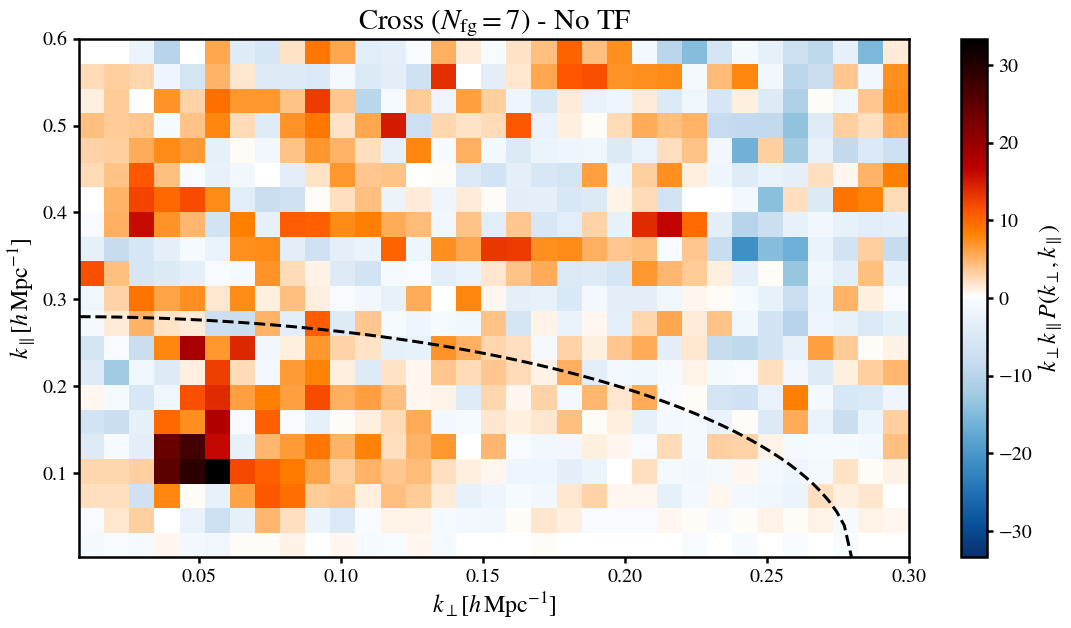

In [9]:
### Chose 2D k-bins:
kperpbins = np.linspace(0.008,0.3,34)
kparabins = np.linspace(0.003,0.6,22)
kperpcen = (kperpbins[1:] + kperpbins[:-1])/2
kparacen = (kparabins[1:] + kparabins[:-1])/2
kperpgrid = np.tile(kperpcen,(len(kparacen),1))
kparagrid = np.tile(kparacen,(len(kperpcen),1))
kparagrid = np.swapaxes(kparagrid,0,1)
kgrid = kperpcen * kparacen[:,np.newaxis]

### Create split colorbar for 2D Pk negative values:
import matplotlib.colors as mcolors
colors1 = plt.cm.Blues_r(np.linspace(0., 1, 128))
colors2 = plt.cm.gist_heat_r(np.linspace(0, 1, 128))
colors = np.vstack((colors1, colors2))
mycmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

Pk2D,k2d,nmodes = power.Pk2D(MKmap_clean_rg,n_g_rg,dims_rg,kperpbins,kparabins,'Cross',w1=w_HI_rg,w2=W01_g_rg,W1=W01_HI_rg,W2=W01_g_rg)

vmaxX = np.max(kgrid*Pk2D)
plt.pcolormesh(kperpbins,kparabins,kgrid*Pk2D,cmap=mycmap,vmin=-vmaxX,vmax=vmaxX)
### 1D k_max contour:
kperp = np.linspace(np.min(kperpbins),kmax,100)
kpara = np.linspace(np.min(kparabins),kmax,100)
kcont = np.sqrt(kmax**2 - kpara**2)
plt.plot(kperp,kcont,color='black',ls='--',lw=3)
plt.colorbar(label=r'$k_\perp k_\parallel P(k_\perp,k_\parallel)$')
plt.xlim(left=kperpbins[0])
plt.ylim(bottom=kparabins[0])
plt.xlabel(r'$k_\perp [h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$k_\parallel [h\,{\rm Mpc}^{-1}]$')
plt.title(r'Cross ($N_{\rm fg}=%s$) - No TF'%N_fgs[indx_choice])
plt.show()

### 2D TFs:

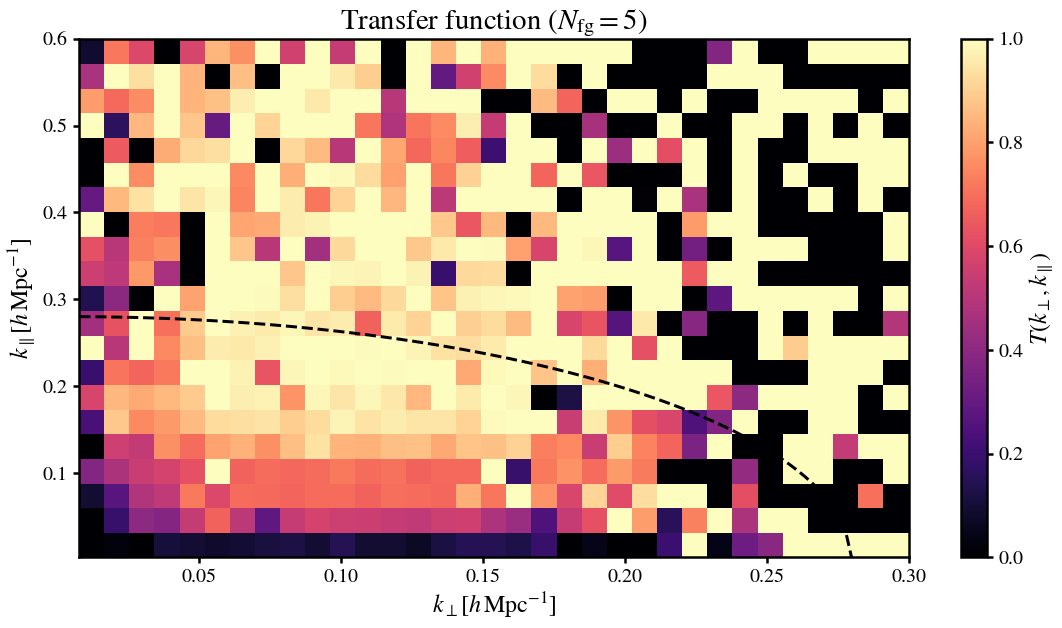

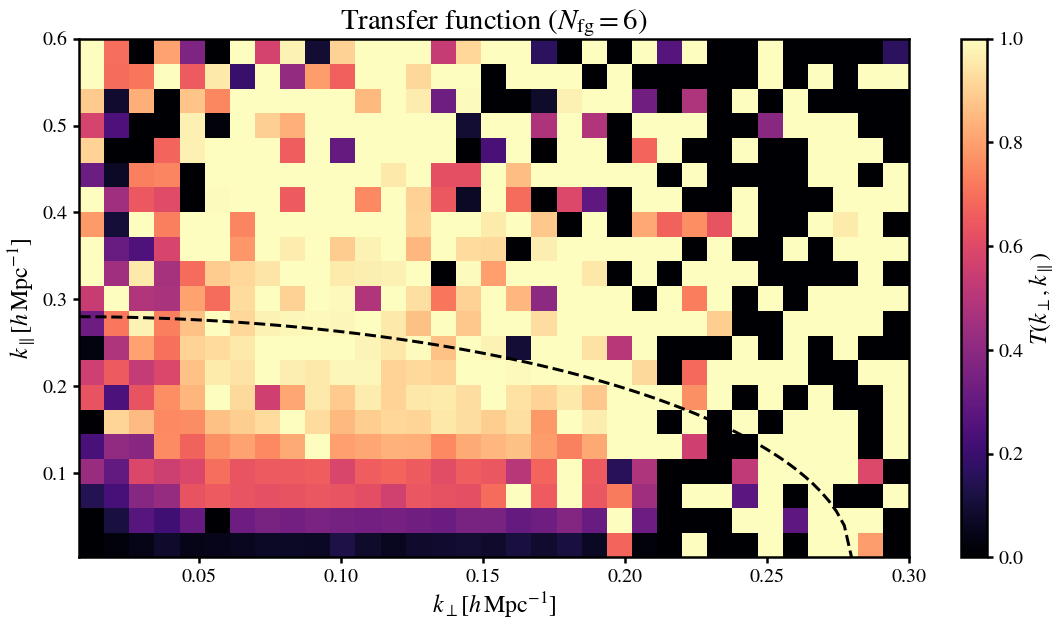

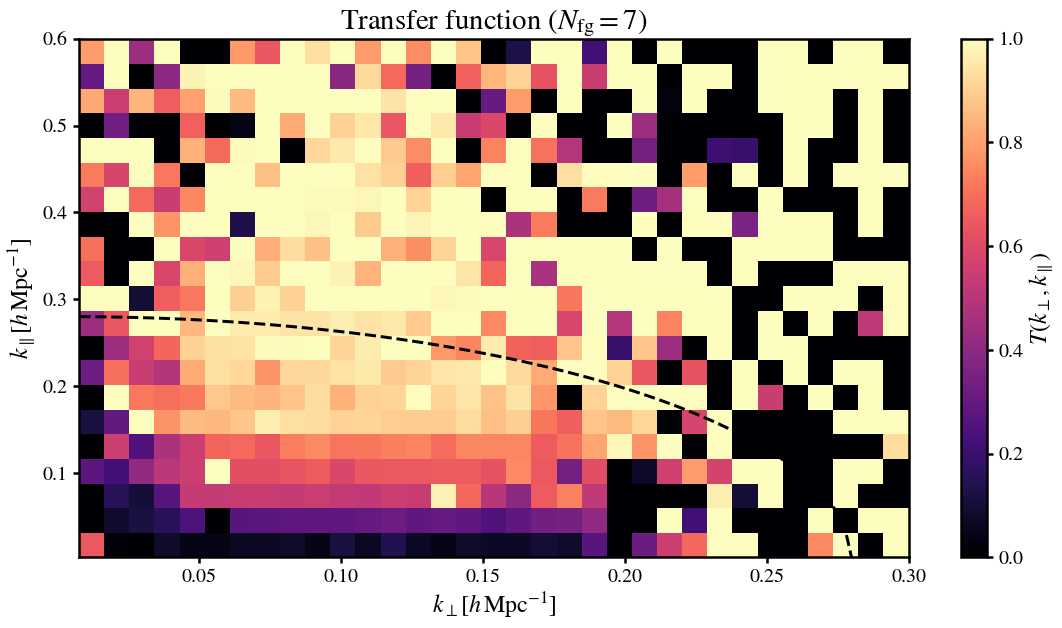

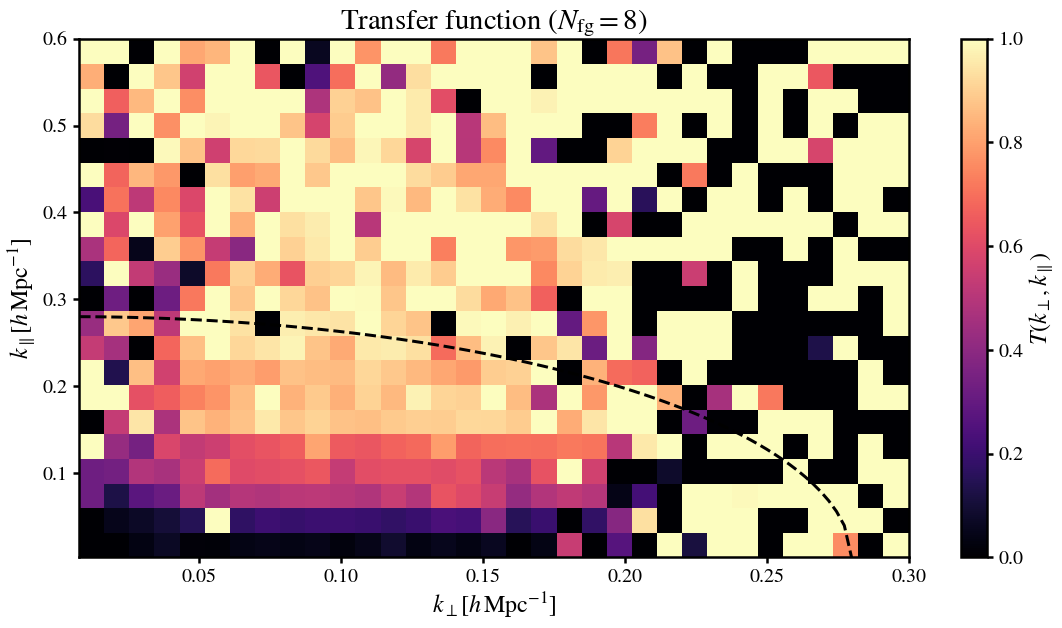

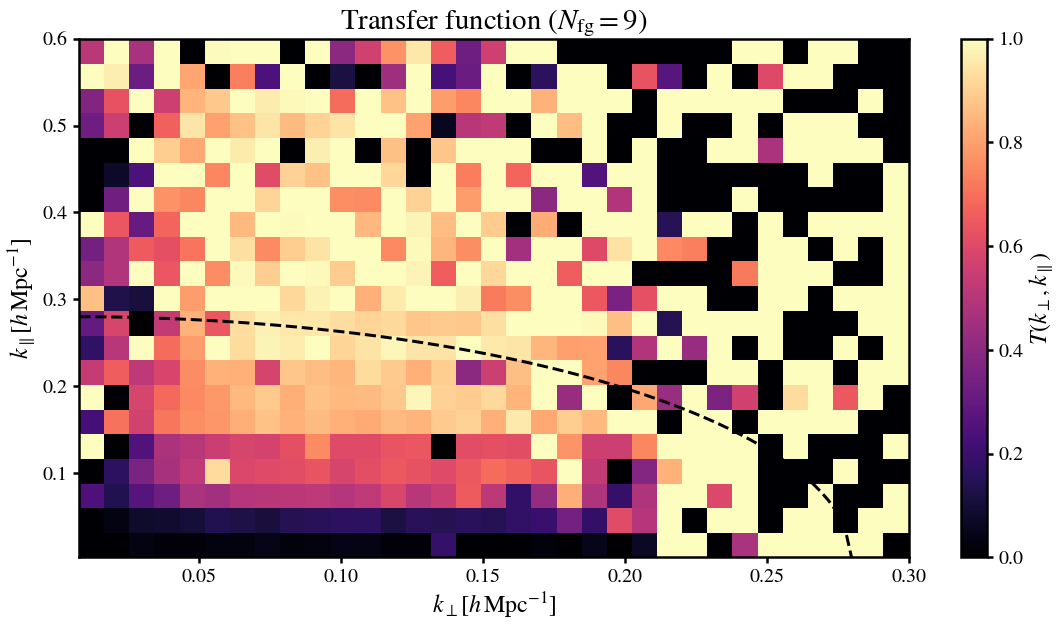

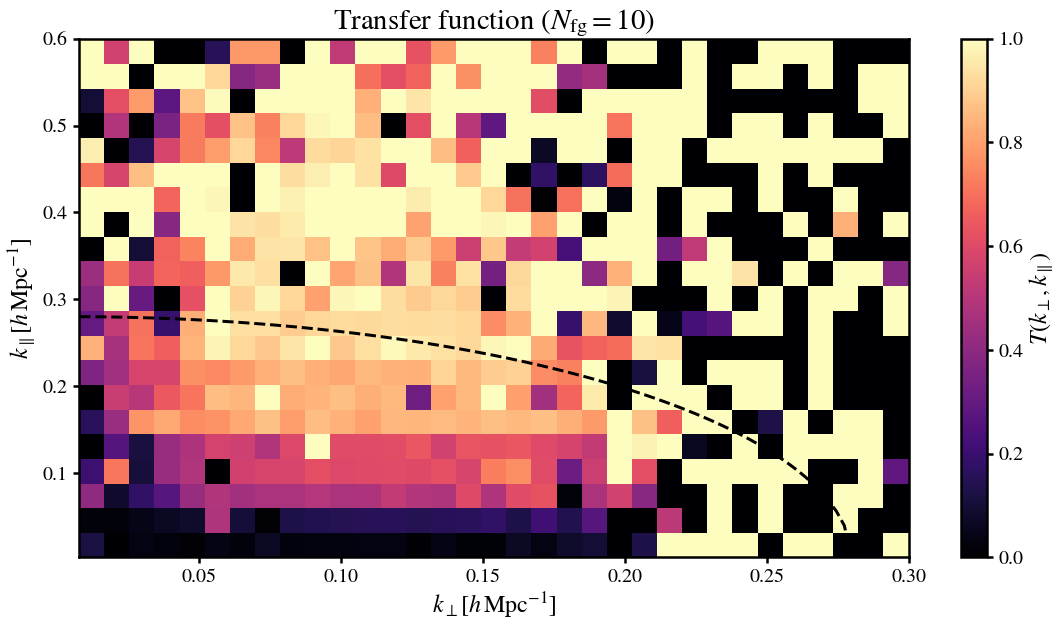

In [10]:
N_fgs_TF = [5,6,7,8,9,10]
for i in range(len(N_fgs_TF)):
    TFfile = '/users/scunnington/hi_im/meerpower/2021Lband/gama/TFdata/T2D_Nfg=%s'%N_fgs_TF[i]
    mockfilepath_HI = '/idia/projects/hi_im/meerpower/2021Lband/mocks/dT_HI_p0.3d_wBeam'
    mockfilepath_g = '/idia/projects/hi_im/meerpower/2021Lband/mocks/mockGAMAcat'
    T2d,k2d = foreground.TransferFunction(MKmap,Nmock,N_fgs[indx_choice],'Cross',kbins,k,TFfile,mockfilepath_HI,mockfilepath_g,W_HI,w_HI_rg,W01_HI_rg,W01_g_rg,W01_g_rg,ra,dec,nu,wproj,dims0_rg,Np,window,compensate,interlace,taper_HI,taper_g,LoadTF,TF2D=True)
    Nmock = np.shape(T)[0]

    plt.pcolormesh(kperpbins,kparabins,np.mean(T2d,0),vmin=0,vmax=1)
    ### 1D k_max contour:
    kperp = np.linspace(np.min(kperpbins),kmax,100)
    kpara = np.linspace(np.min(kparabins),kmax,100)
    kcont = np.sqrt(kmax**2 - kpara**2)
    plt.plot(kperp,kcont,color='black',ls='--',lw=3)
    plt.colorbar(label=r'$T(k_\perp,k_\parallel)$')
    plt.xlim(left=kperpbins[0])
    plt.ylim(bottom=kparabins[0])
    plt.xlabel(r'$k_\perp [h\,{\rm Mpc}^{-1}]$')
    plt.ylabel(r'$k_\parallel [h\,{\rm Mpc}^{-1}]$')
    plt.title(r'Transfer function ($N_{\rm fg}=%s$) '%N_fgs_TF[i])
    plt.show()
    